In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['font.family'] = 'Arial'
import matplotlib.patches as mpatches
import scipy.stats as stats

matlab_lines = np.array([[0,0.447,0.741],[0.85,0.325,0.098],[0.929,0.694,0.125],[0.494,0.184,0.556],
                         [0.466,0.674,0.188],[0.301,0.745,0.933],[0.635,0.078,0.184]])

#Code below for "unit invariant" SVD adapted from MATLAB code in http://arxiv.org/abs/1604.08476
def dscale(A):
    tol = 1e-15; 
    m = np.size(A,axis=0)
    n = np.size(A,axis=1)
    L = np.zeros((m, n))
    M = np.ones((m, n))
    S = np.sign(A)
    A = np.abs(A)
    L[A>0.0] = np.log(A[A>0.0])
    L[A==0] = 0
    M[A==0] = 0
    r = np.sum(M, axis=1)
    c = np.sum(M, axis=0)
    u = np.zeros((m, 1))
    v = np.zeros((1, n))
    dx = 2*tol

    while dx > tol: 
        idx = c > 0
        p = np.sum(L[:,idx], axis=0)/c[idx]
        L[:,idx] = L[:,idx] - p * M[:,idx]
        v[0,idx] = v[0,idx] - p
        dx = np.mean(np.abs(p))
        idx = r > 0
        p = np.sum(L[idx,:],axis=1)/r[idx]
        L[idx,:] = L[idx,:] - p.reshape(-1,1) * M[idx, :]
        u[idx,0] = u[idx,0] - p
        dx = dx + np.mean(np.abs(p))

    dl = np.exp(u)
    dr = np.exp(v)
    S  = S*np.exp(L)
    return [S, dl, dr]

def usv_decomp(A):
    m = np.size(A,axis=0)
    n = np.size(A,axis=1)
    [S, dl, dr] = dscale(A)
    D = np.diag(np.divide(1,dl).ravel())
    E = np.diag(np.divide(1,dr).ravel())
    [U, S, V] = np.linalg.svd(S)
    S = np.concatenate((np.diag(S),np.zeros((m-n,n))),axis=0)
    return [D, U, S, V.T, E]

In [6]:
#load data
E = pd.read_csv('env_vars.csv',delimiter = ",",index_col=0)
E = E.drop(columns=['DistEqu','SoilC_from_database','Fire']) #drop variables taken from a database, or data redundant with lat/lon
latlon = pd.read_csv('sample_coordinates.csv',delimiter = ",", index_col=0) #scraped from NCBI
E = pd.concat([E,latlon],axis=1)
KO_counts = pd.read_excel('absolute_counts.xlsx',index_col=0)
KO_labels = pd.read_csv('denit_kos.tsv',delimiter = "\t",header = None)

#relabel columns
KO_counts = KO_counts.rename(columns=dict(zip(KO_labels.values[:,0],  KO_labels.values[:,1])))
KO_counts = KO_counts.rename(columns={-1: "total"})
KO_counts = KO_counts.drop(columns = ["narX","norR","nnrS","nsrR","narK","nrfA","hao"]) #drop non-reductases

#normalize by total counts
KO_norm = KO_counts.copy()
KO_norm = KO_norm.div(KO_norm.total,axis=0)
KO_norm = KO_norm.drop(columns = ["total"])

data = pd.concat([KO_norm,E],axis=1)
# data = data[KO_counts.drop(columns=["total"]).sum(axis=1) > 10] #filter out low counts data?

N = len(data)
M = len(KO_norm.columns)
N

189

Plot datapoints on map (not essential)

In [3]:
import geopandas as gpd
# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
plt.figure(figsize=(8,8))
worldmap.plot(color=[0.9,0.9,0.9])


x = data['longitude']
y = data['latitude']
plt.scatter(x, y, alpha=0.75, c=data['pH'],marker = '.',cmap = 'inferno_r')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])
plt.xticks([])
plt.yticks([])
plt.colorbar(shrink = 1,location='bottom')
plt.savefig('Fig1_map.svg')
plt.savefig('Fig1_map.png',dpi = 300)

ImportError: dlopen(/Users/seppekuehn/opt/miniconda3/lib/python3.7/site-packages/fiona/ogrext.cpython-37m-darwin.so, 2): Library not loaded: @rpath/libgif.7.dylib
  Referenced from: /Users/seppekuehn/opt/miniconda3/lib/libgdal.20.dylib
  Reason: image not found

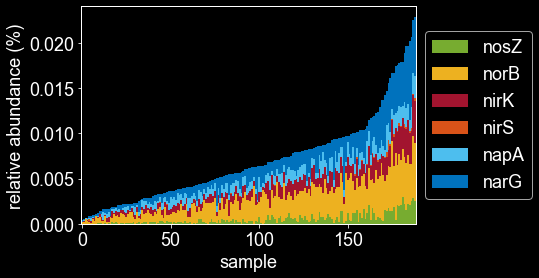

In [9]:
colors = [matlab_lines[0],matlab_lines[5],matlab_lines[1],matlab_lines[6],matlab_lines[2],matlab_lines[4]]
width = 1
G = data.values[:,0:M]
plt.style.use('dark_background')
plt.rcParams.update({'font.size': 18})

plot_idx = np.argsort(np.sum(G,axis=1))

N = np.shape(G)[0]
M = np.shape(G)[1]

bottom = np.zeros(N)
for i in range(0,M):
    plt.bar(range(0,N), 100*G[plot_idx,M-i-1], width, bottom=bottom, color=colors[M-i-1]);
    bottom = bottom + 100*G[plot_idx,M-i-1]
    
plt.xlabel('sample');
plt.ylabel('relative abundance (%)');
plt.xlim([-0.5,N-0.5]);
plt.legend(np.flip(data.columns[0:M]),loc='center left', bbox_to_anchor=(1, 0.5));
plt.savefig('Fig1_abund.svg')

Regressions on the raw gene relative abundances

/Users/seppekuehn/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


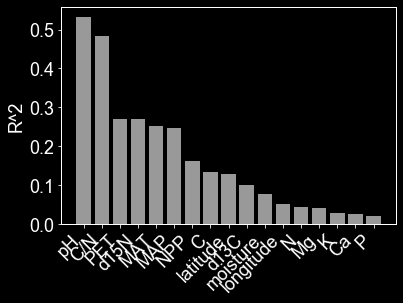

In [10]:
from sklearn import linear_model
# from sklearn.model_selection import RepeatedKFold
# from sklearn.model_selection import cross_val_score
# from sklearn import metrics
from sklearn.preprocessing import StandardScaler

Ys = list(data.columns[M:])
r2 = pd.DataFrame(np.zeros((1,len(Ys))),columns = Ys)
coefs = pd.DataFrame(np.zeros((len(Ys),M)),columns = data.columns[0:M], index = Ys)
# cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0) #5-fold iterated cross-validation
scaler = StandardScaler()

for var in Ys:
    in_data = pd.concat([data[data.columns[0:M]],data[var]],axis=1).copy()
    in_data = in_data.dropna(how='any')
    Y = np.ravel(in_data[var])
    Y = (Y - np.mean(Y))/np.std(Y) #scale the environmental variable
    X = scaler.fit_transform(in_data[in_data.columns[0:M]].values) #scale each feature
    
#     model = linear_model.LassoCV(cv=cv,max_iter=10000,fit_intercept=False).fit(X,Y) #Fit a lasso  model
    model = linear_model.LinearRegression(fit_intercept=False).fit(X,Y) #fit an OLS model
    r2[var] = model.score(X,Y)
    coefs.loc[var] = model.coef_

idx = np.flip(np.argsort(r2.values))
labels = np.ravel(r2.columns[idx])
values = np.ravel(r2.values[:,idx])


# plt.figure(figsize=(12, 6))
plt.bar(labels,values,color = [0.6,0.6,0.6] )
plt.xticks(rotation = 45,ha='right');
plt.ylabel('R^2');
plt.savefig('Fig1_E_R2.svg')
# plt.savefig('Fig1_E_R2.png',dpi = 300)

Perform unit-invariant SVD to produce a scaling prefactor matrix D, a "compositional" matrix C, and a "scores" matrix T which has the projections of the compositions onto the eigenvectors in V.

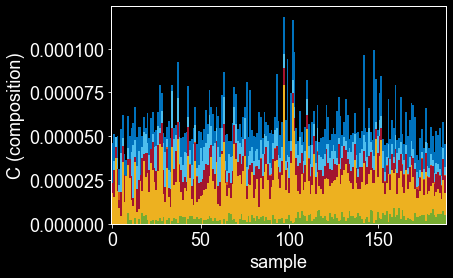

/Users/seppekuehn/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


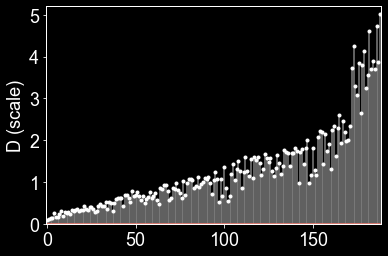

In [12]:
[D,U,S,V,E] = usv_decomp(G)

D = pd.DataFrame(data=np.diag(D),index=data.index) #scaling values
C = pd.DataFrame(data=U @ S @ V.T @ E, index=data.index,columns = data.columns[0:M]) #compositions

# #uncomment to perform an SVD directly on C (to eliminate the E matrix)
# [U, S, V] = np.linalg.svd(C.values)
# V = V.T
# S = np.concatenate((np.diag(S),np.zeros((N-M,M))),axis=0)

T = pd.DataFrame(data=U @ S,index=data.index) #score matrix

bottom = np.zeros(N)
for i in range(0,M):
    plt.bar(range(0,N), C.values[plot_idx,M-i-1], width, bottom=bottom, color=colors[M-i-1]);
    bottom = bottom + C.values[plot_idx,M-i-1]
    
plt.xlabel('sample');
plt.ylabel('C (composition)');
plt.xlim([-0.5,N-0.5]);
plt.savefig('Fig1_C.svg')
plt.show()

plt.stem(range(0,N),D.values[plot_idx],markerfmt='w.',linefmt='grey')
# plt.plot(range(0,N),D.values,'.')
plt.ylabel('D (scale)');
plt.xlim([-0.5,N-0.5]);
plt.ylim([0,5.2])
plt.savefig('Fig1_D.svg')
plt.show()


Regressions on composition factors (C)

/Users/kvg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


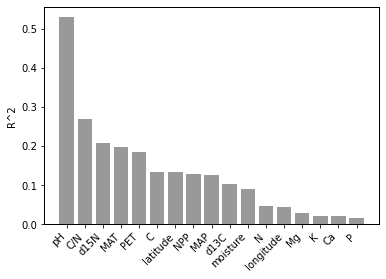

In [6]:
from sklearn import linear_model
# from sklearn.model_selection import RepeatedKFold
# from sklearn.model_selection import cross_val_score
# from sklearn import metrics
from sklearn.preprocessing import StandardScaler

Ys = list(data.columns[M:])
r2 = pd.DataFrame(np.zeros((1,len(Ys))),columns = Ys)
coefs = pd.DataFrame(np.zeros((len(Ys),M)),columns = data.columns[0:M], index = Ys)
# cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0) #5-fold iterated cross-validation
scaler = StandardScaler()

for var in Ys:
    in_data = pd.concat([C,data[var]],axis=1).copy()
    in_data = in_data.dropna(how='any')
    Y = np.ravel(in_data[var])
    Y = (Y - np.mean(Y))/np.std(Y) #scale the environmental variable
    X = scaler.fit_transform(in_data[in_data.columns[0:M]].values) #scale each feature
    
#     model = linear_model.LassoCV(cv=cv,max_iter=10000,fit_intercept=False).fit(X,Y) #Fit a lasso  model
    model = linear_model.LinearRegression(fit_intercept=False).fit(X,Y) #fit an OLS model
    r2[var] = model.score(X,Y)
    coefs.loc[var] = model.coef_

idx = np.flip(np.argsort(r2.values))
labels = np.ravel(r2.columns[idx])
values = np.ravel(r2.values[:,idx])


# plt.figure(figsize=(12, 6))
plt.bar(labels,values,color = [0.6,0.6,0.6] )
plt.xticks(rotation = 45,ha='right');
plt.ylabel('R^2');
plt.savefig('Fig1_C_R2.svg')
# plt.savefig('Fig1_E_R2.png',dpi = 300)

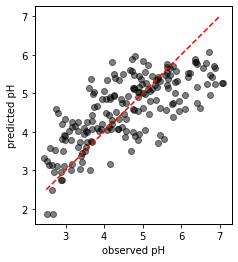

In [7]:
in_data = pd.concat([C,data['pH']],axis=1).copy()
in_data = in_data.dropna(how='any')
Y = np.ravel(in_data['pH'])
X = scaler.fit_transform(in_data[in_data.columns[0:M]].values) #scale each feature
model = linear_model.LinearRegression(fit_intercept=True).fit(X,Y) #fit an OLS model

plt.plot([2.5,7.],[2.5,7.],'r--')
plt.scatter(Y,model.predict(X),color='k',alpha=0.5)
plt.gca().set_aspect('equal')
plt.xlabel('observed pH');
plt.ylabel('predicted pH');
# plt.yticks([-2,-1,0,1,2]);
plt.savefig('Fig1_obsvspred.svg')

Regressions on scaling factor (D).

/Users/kvg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


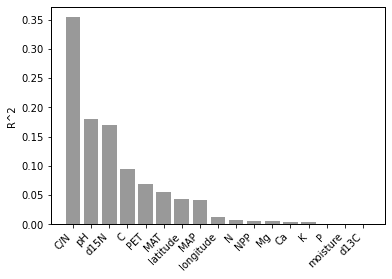

In [8]:
from sklearn import linear_model
# from sklearn.model_selection import RepeatedKFold
# from sklearn.model_selection import cross_val_score
# from sklearn import metrics

Ys = list(data.columns[M:])
r2 = pd.DataFrame(np.zeros((1,len(Ys))),columns = Ys)
# cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0) #5-fold iterated cross-validation

for var in Ys:
    in_data = pd.concat([D,data[var]],axis=1).copy()
    in_data = in_data.dropna(how='any')
    Y = np.ravel(in_data[var])
    Y = (Y - np.mean(Y))/np.std(Y) #scale the environmental variable
    X = in_data[0].values.reshape(-1,1)
    X = (X - np.mean(X))/np.std(X) #scale the scaling variable
    
#     model = linear_model.LassoCV(cv=cv,max_iter=10000,fit_intercept=False).fit(X,Y) #Fit a lasso  model
    model = linear_model.LinearRegression(fit_intercept=False).fit(X,Y) #fit an OLS model
    r2[var] = model.score(X,Y)

idx = np.flip(np.argsort(r2.values))
labels = np.ravel(r2.columns[idx])
values = np.ravel(r2.values[:,idx])


# plt.figure(figsize=(12, 6))
plt.bar(labels,values,color = [0.6,0.6,0.6] )
plt.xticks(rotation = 45,ha='right');
plt.ylabel('R^2');
plt.savefig('Fig1_D_R2.svg')
# plt.savefig('Fig1_E_R2.png',dpi = 300)

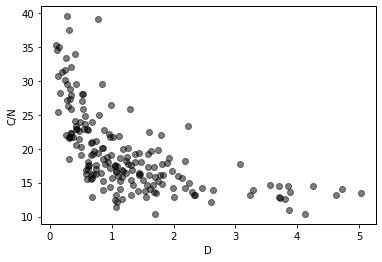

In [9]:
plt.scatter(D.values.flatten(),data['C/N'].values.flatten(),color='k',alpha=0.5);
plt.xlabel('D');
plt.ylabel('C/N');
plt.savefig('Fig1_D_vs_CN.svg')

Regressing each score vector (corresponding to compositions projected onto a particular eigenvector) against the E variables

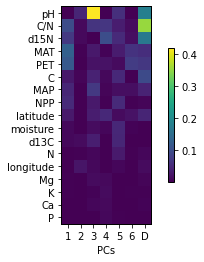

In [11]:
Ys = np.array((data.columns[M:]))
rs    = pd.DataFrame(np.zeros((len(Ys),M+1)), index = Ys)
# cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0) #5-fold iterated cross-validation

for var in Ys:
    in_data = pd.concat([T,D.rename(columns={0:6}),data[var]],axis=1).copy()
    in_data = in_data.dropna(how='any')
    for j in range(0,M+1):
        Y = np.ravel(in_data[var])
        X = in_data[j].values
        
        rs.loc[var][j] = stats.pearsonr(X,Y)[0]**2
        
nplot = len(Ys)
idx = np.flip(np.argsort(np.max(rs,axis=1)).values)
plt.imshow(rs.iloc[idx[0:nplot]]);
plt.colorbar(fraction=0.02);
plt.yticks(ticks=range(0,len(Ys[0:nplot])),labels=Ys[idx[0:nplot]],ha='right');
plt.xticks(ticks=range(0,M+1),labels=['1','2','3','4','5','6','D']);
plt.xlabel('PCs');
plt.savefig('Fig1_PCs_E.svg')

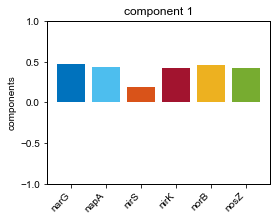

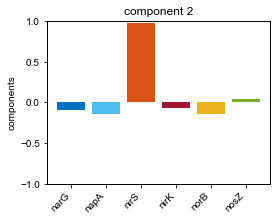

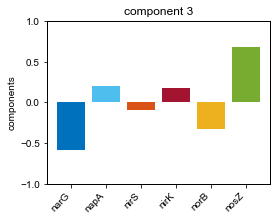

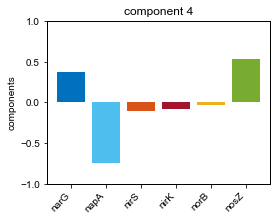

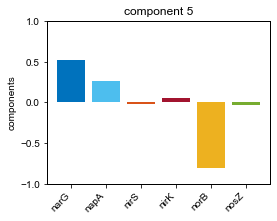

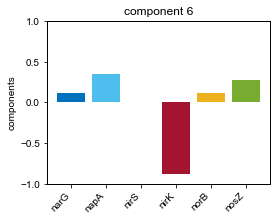

In [15]:
for i in range(0,M):
    sgn = np.sign( np.corrcoef(T[i],data['pH'])[0,1] ) #get sign of relationship between scores and pH
    plt.figure(figsize=(4, 3))
    plt.bar(data.columns[0:M],sgn*V[:,i],color = colors)
    plt.ylabel('components');
    plt.xticks(rotation = 45,ha='right');
    plt.yticks([-1,-0.5,0.0,0.5,1.0])
    plt.ylim([-1,1])
    plt.title('component ' + str(i+1))
    plt.savefig('Fig1_PC'+str(i+1)+'.svg')
    plt.show()

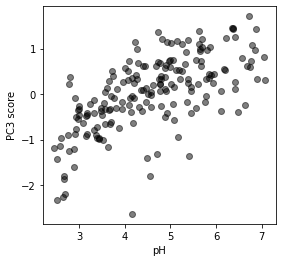

In [81]:
plt.scatter(data['pH'],T.values[:,2],color='k',alpha=0.5);
plt.xlabel('pH');
plt.ylabel('PC3 score');
ax = plt.gca()
ax.set_aspect(1)

plt.savefig('Fig1_ph_vs_PC3.svg')

Shuffle null of corr coeff.

In [120]:
X = data['pH']
nrep = 100000

corrs = np.zeros(nrep)
for i in range(0,nrep):
    Y = T.values[:,2] #PC3
    np.random.shuffle(Y)
    corrs[i] = np.corrcoef(X,Y)[1,0]**2
    
np.sum(corrs>rs[2].pH)

0